# Project: Machine Learning Advanced - Face Detection system for digital camera

La ProCam S.p.A. intends to launch a new compact and affordable digital camera targeted towards aspiring photographers.

You have been hired as a Data Scientist to develop a face identification system for images.
This system will enable photography technicians to optimize settings for selfies with one or more people.

The task involves a computer vision problem, specifically Face Detection.

You are required to create a scikit-learn pipeline that takes an image as input and returns a list containing the coordinates of bounding boxes where faces are detected.
If the image does not contain any faces, the list will be empty.

## Project Analysis

### Dataset: Free dataset to be used and reasons to use it

For the project, no dataset was provided. 
For this reason, an online search was conducted to find a free dataset containing human faces to train the model for face recognition and address the Face-Recognition problem.

The chosen dataset is the [Real and Fake Face Detection](https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection), retrieved from Kaggle. 

The dataset contains the real and fake image of faces.
For the purpose of project is chosen to take only the real part of dataset that contains a lot of faces in frontal camera with different expression and colour. 

**Considering that the model will run on a digital camera, it was needed essential to use such a diverse dataset. 
This is especially important given photographers who may take photos in numerous different circumstances.**

For the negative dataset has been chosen the following dataset [Animals-10](https://www.kaggle.com/datasets/alessiocorrado99/animals10).

### Data Pre-Processing: Approach to define features to train model

The model must be trained using images that depict faces in various circumstances, which is why it is crucial to establish a robust data pre-processing phase.

Given the presence of images, the dataset needs to be created by extracting features from the images. The goal of this phase is to extract textures and patterns from the images that can assist the model in identifying the presence or absence of a face.

#### Local Binary Pattern

As extraction techniques, Local Binary Pattern (LBP) and Local Derivative Pattern have been chosen, proving useful for extracting local features from each image.

The LBP technique involves [](https://www.sciencedirect.com/science/article/abs/pii/B9780128155530000136) [2]
[](https://www.sciencedirect.com/science/article/abs/pii/B9780081007051000063) [3]:

1. Converting the images to grayscale.

\begin{equation}
\text{Central pixel: } I_C \\
\text{Nearest pixels: } I_{P_i}
\end{equation}

2. Selecting a central pixel of the image, considering a typically square "window," and comparing the intensities of the pixels composing the "window" with its central pixel.

\begin{equation}
LBP_P^{R}(x, y) = \sum_{p=0}^{P-1} s(I_{p} - I_{c}) \cdot 2^p
\end{equation}

3. Assign the value 1 to pixel with value greater than central pixel otherwise 0

\begin{equation}
s(x) = \begin{cases} 
1 & \text{if } x \geq 0 \\
0 & \text{otherwise}
\end{cases}
\end{equation}

4. Treating the resulting binary sequence as a binary number, subsequently converted to decimal.

\begin{equation}
\text{Binary patern: } P_1P_2...P_P
\end{equation}

\begin{equation}
\text{Decimal number: } D = \sum_{i=0}^{P-1} 2^i \cdot P_i
\end{equation}

5. The obtained numerical value represents the local binary pattern for the point of interest and is assigned to the reference pixel of the image.

\begin{equation}
I_C = D
\end{equation}

[scikit-learn](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_local_binary_pattern.html) [1]
[Science paper](https://www.sciencedirect.com/science/article/abs/pii/B9780128155530000136) [2]
[Science paper](https://www.sciencedirect.com/science/article/abs/pii/B9780081007051000063) [3]

#### Histogram of Orientied Gradient

The second technique used to extract the features from images is Histogram of Oriented Gradient.

It works by calculating the distribution of gradient orientations in an image to represent the local object shape and appearance. HOG has been widely used in tasks such as pedestrian detection, face recognition, and object tracking. 
[HOG - Blog Post](https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/#:~:text=HOG%2C%20or%20Histogram%20of%20Oriented,vision%20tasks%20for%20object%20detection)

### Model: How to create the model

The model will need to run on a digital camera, implying that it should use minimal computational resources to detect human faces.

*This consideration leads to the exclusion of all Deep Learning models such as Neural Networks, which inherently require much greater computational power compared to classical Machine Learning models.*

The approach, therefore, is to explore alternative solutions to Deep Learning and create a lightweight and efficient model that can solve the Face Recognition problem.

Solutions will be explored using the following model:

- SVM

For each model, a reasearch for **the best hyperparameters will be conducted using HalvingRandomizedSearch**, which will help find the **best estimator** for face and non-face classification.

#### Comparison: Combine HOG and LBP with SVM

Next, all selected models for each technique, LBP and HOG, will be compared with each other through the evaluation of metrics such as scikit-learn's classification report, log loss, and score.

Finally, a pipeline will be created with scikit-learn, encompassing data preprocessing steps, in this case, for images, a potential reduction of dataset dimensionality to lighten the model and pipeline, and lastly, the model that will identify the presence of a face.

Additionally, the code will display on the input photo the polygon containing the detected human face.

# 1 - Import Section






In [70]:
# Utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from os import listdir
from collections import Counter
from PIL import Image
from io import BytesIO
from skimage import exposure
import scipy
import zipfile
import io
import imutils

# Dataset loader
from sklearn.model_selection import train_test_split

# Pre processing
from sklearn.preprocessing import StandardScaler, FunctionTransformer

# Feature selector
from sklearn.decomposition import PCA
from skimage.feature import local_binary_pattern, hog

# Model
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import RandomizedSearchCV, HalvingRandomSearchCV, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator

# Metrics
from sklearn.metrics import classification_report, log_loss, confusion_matrix
from sklearn.model_selection import cross_val_score

# Composer and Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

## 2 - Constant Declaration Section

In [2]:
# Random seed to allow to replicate the same results
RANDOM_SEED = 0

# Base path
BASE_PATH = "C:\\Users\\39366\\Desktop\\face_detector_project\\"

# Test path
TEST_CLASSIFICATION_PATH = "classification_model_tests\\"
TEST_FD_PATH = "fd_model_tests\\"

# Folder path where to find all images to use for train model
PATH_DATASET = "image_dataset_face_recognition\\"

# Folder name for negative and positive image
IMAGE_POSITIVE_FOLDER = "images_positive\\"
IMAGE_NEGATIVE_FOLDER = "images_negative\\"

# Image size
IMAGE_SIZE = (128, 128)

# Factor scale for pyramid
SCALE_PYRAMID = 1.5

# Target labels
LABELS = [0, 1]

## 3 - Function Section

### 3.1 - Function: Dataset loader

In [3]:
def load_dataset_from_memory(labels_type='pos'):
    """
    Function used to read from a specific folder all the images contained.
    
    Parameters:
    - labels_type: string, label type to identify positive or negative images data.

    Returns:
    - X: ndarray, images.
    - y: ndarray, labels for each image.
    """
    X = []
    y = []

    if labels_type == 'pos':
        path = BASE_PATH + PATH_DATASET + IMAGE_POSITIVE_FOLDER
    else:
        path = BASE_PATH + PATH_DATASET + IMAGE_NEGATIVE_FOLDER

    for f in listdir(path):
        if '.png' or '.jpg' in f:
            image = cv2.imread(path+f, cv2.IMREAD_GRAYSCALE)
            image_equalized = cv2.equalizeHist(image)
            image_resized = resize_image(image_equalized)
            X.append(image_resized)
            if labels_type == 'pos':
                y.append(LABELS[1])
            else:
                y.append(LABELS[0])

    return np.array(X), np.array(y)

### 3.2 - Functions to extract features HOG and LBP

In [4]:
def extract_features_from_list_image_hog(image_list):
    """
    Function used to extract from a list of images the Local Binary Pattern features.

    Parameters:
    - image_list: list, image list where extract features.

    Returns:
    - ndarray, hog features extracted.
    - ndarray, image hog.
    """

    # Initialize hog feature and image lists
    image_hog_features = []
    image_hog = []

    # Loop over images into list
    for img in image_list:

        # Extract the hog features and hog image
        hog_feature, hog_image = compute_hog(img)

        # Append the feature and image to hog lists
        image_hog_features.append(hog_feature)
        image_hog.append(hog_image)

    # Return numpy arrays of hog features and hog images
    return np.array(image_hog_features), np.array(image_hog)


def extract_features_from_list_image_lbp(image_list):
    """
    Function used to extract from a list of images the Local Binary Pattern features.

    Parameters:
    - image_list: list, image list where extract features.

    Returns:
    - ndarray, lbp features extracted.
    """

    # Initialize lbp feature list
    lbp_features = []

    # Loop over images into list
    for img in image_list:

        # Append the feature extracted to lbp list
        lbp_features.append(compute_lbp(img))

    # Return the numpy array with lbp features
    return np.array(lbp_features)


def plot_image_and_features(original_image, hog_image, lbp_image):
    """
    Plot the original image, Histogram of Oriented Gradients (HOG) image, and Local Binary Pattern (LBP) image.

    Parameters:
    - original_image: ndarray, the original input image.
    - hog_image: ndarray, the HOG image.
    - lbp_image: ndarray, the LBP image.
    """

    # Set up 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)

    # Set the original image
    ax1.imshow(original_image, cmap=plt.cm.gray)
    ax1.set_title('Input image')

    # Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Set the HOG image
    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')

    # Set the LBP image
    ax3.imshow(lbp_image, cmap=plt.cm.gray)
    ax3.set_title('Local Binary Pattern')

    # Show the images
    plt.show()

### 3.3 - Functions to processing images

In [5]:
def compute_lbp(image, radius=1, n_points=8):
    """
    Extract features with Local Binary Pattern.

    Parameters:
    - image: ndarray, image to be resize.
    - radius: int, radius of circle.
    - n_points: int, number of points on circle.

    Returns:
    - ndarray, lbp feature extracted.
    """

    # Extract local binary pattern from image
    return local_binary_pattern(image, n_points, radius, method="uniform")


def compute_hog(image):
    """
    Extract features with Histogram of Oriented Gradients.

    Parameters:
    - image: ndarray, where extract features.

    Returns:
    - ndarray, hog features extracted.
    """

    # Initiliaze HOG class
    hog_feature, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)

    hog_feature = exposure.equalize_hist(hog_feature)

    # Extract features from image
    return hog_feature, hog_image


def resize_image(image, target_size=IMAGE_SIZE):
    """
    Resize image with specified size.

    Parameters:
    - image: ndarray, image to be resize.
    - target_size: tuple, new size use to resize (default: (224, 224)).

    Returns:
    - ndarray, image resized.
    """

    # Return the image resized
    return cv2.resize(image, target_size)


def grayer_image(image):
    """
    Execute the transform into gray scale of image.

    Parameters:
    - image: ndarray, image to be grayed.

    Returns:
    - ndarray, image in gay scale.
    """

    # Return the image in gray scale
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

### 3.4 - Function to create, evaluate and test models

In [6]:
def svc_create_and_fit_model(kwargs, x, y):
    """
    Create a SVC model with arguments (kwargs) and train it on x and y.

    Parameters:
    - kwargs: arguments, arguments to be used for SVC creation.
    - x: ndarray, train features set.
    - y: ndarray, train labels set

    Returns:
    - SVC model trained.
    """

    # Initialize the SVC model with arguments
    model = SVC(**kwargs)

    # Train the SVC model
    model.fit(x, y)

    # Return the model
    return model


def evaluate_model(model, x, y, x_test, y_test):
    """
    Evaluate models using:
        - Cross-validated Accuracy
        - Log loss on train and test
        - Classification report on train and test

    Parameters:
    - model: model object, model to be evaluted.
    - x: ndarray, train features set.
    - y: ndarray, train labels set
    - x_test: ndarray, test features set
    - y_test: ndarray, test labels set
    """

    # Print all metrics related to the model
    scores = cross_val_score(model, x, y, cv=5)
    print("Cross-validated Accuracy: ", scores.mean())
    print("\nLog Loss on Train: ", log_loss(y, model.predict(x)))
    print("\nLog Loss on Test: ", log_loss(y, model.predict(x)))
    print("\nClassification report on Train: \n", classification_report(model.predict(x), y))
    print("\nClassification report on Test: \n", classification_report(model.predict(x_test), y_test))
    
    
def plot_confusion_matrix(y_true, y_pred, labels=["Negative", "Positive"], show_precision=True, show_recall=True):
    """
    Plot the confusion matrix.

    Parameters:
    - y_true: ndarray, true labels.
    - y_pred: ndarray, predicted labels.
    - labels: list of str, optional, class labels for the confusion matrix. Default is ["Negative", "Positive"].
    - show_precision: bool, optional, flag to display precision values. Default is True.
    - show_recall: bool, optional, flag to display recall values. Default is True.
    """
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)  # tn, fp, fn, tp 

    # Create a DataFrame for better visualization
    df_cm = pd.DataFrame(cm,
                         index=labels,
                         columns=["Predicted "+labels[0], "Predicted "+labels[1]])

    # Plot the heatmap
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')


def test_model(model, image, excepted_result):
    """
    Test the model on data input.

    Parameters:
    - model: model object, model used for test.
    - image_path: string, path of image to be tested.
    - expected_result: int, expected result of test.
    - is_PCA: boolean, flag to decide if apply or not the PCA.
    - lbp_flag: boolean, flag to decide if apply lbp.
    - hog_flag: boolean, flag to decide if apply hog.
    """
    
    # Execute prediction
    test_result = model.predict(image)

    # Check the result with expected result
    if test_result[0] == int(excepted_result):
        print(f'Test Passed! The test result is {test_result[0]} and expected result {excepted_result}')
    else:
        print(f'Test Failed! The test result is {test_result[0]} and expected result {excepted_result}')


def apply_PCA(n_components, X_train, X_test):
    """
    Apply PCA to the features.

    Parameters:
    - n_components: int, number of components to consider during PCA.
    - X_train: ndarray, train features set.
    - X_test: ndarray, test features set.

    Returns:
    - pca object and train and test features set with PCA.
    """
    
    # Initialize PCA
    pca = PCA(n_components=n_components, random_state=RANDOM_SEED)

    # Apply PCA
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    
    return pca, X_train, X_test

def apply_standardization(X_train, X_test):
    """
    Apply standardization to the features.

    Parameters:
    - X_train: ndarray, train features set.
    - X_test: ndarray, test features set.

    Returns:
    - StandardScaler object and standardized train and test features set.
    """
    ss = StandardScaler()

    # Fit and transform the training set
    X_train = ss.fit_transform(X_train)

    # Transform the test set using the parameters learned from the training set
    X_test = ss.transform(X_test)

    return ss, X_train, X_test


def compute_features_selection_on_PCA(x, n_initial_features):
    """
    Compute variance explained by PCA components.

    Parameters:
    - x: ndarray, features set.
    - n_initial_features: int, number of initial features.

    Returns:
    - ndarray, cumulative variance explained by PCA components.
    """
    
    # Initialize PCA
    pca = PCA(n_components=n_initial_features, random_state=RANDOM_SEED)

    # Fit PCA to the features
    pca.fit(x)

    # Compute cumulative variance explained by PCA components
    variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3) * 100)

    return variance


def show_variance_explained_PCA(variance):
    """
    Plot the variance explained by PCA components.

    Parameters:
    - variance: ndarray, cumulative variance explained by PCA components.
    """
    
    # Create the plot for Variance
    plt.ylabel('% Variance Explained')
    plt.xlabel('# of Features')
    plt.title('PCA Analysis')
    plt.ylim(30, 100.5)
    plt.style.context('seaborn-whitegrid')
    plt.plot(variance)


def show_features_PCA(x_pca, y_pca):
    """
    Plot the features computed from PCA.

    Parameters:
    - x_pca: ndarray, features pca.
    - y_pca: ndarray, labels pca.
    """

    # Set plot dimension
    plt.figure(figsize=(8,6))

    # Create scatterplot for PCA features and labels
    plt.scatter(x_pca[:,0],x_pca[:,1],c=y_pca,cmap='plasma')

    # Set the labels to x and y axis
    plt.xlabel('First principal component')
    plt.ylabel('Second Principal Component')

### 3.5 - Function to find best hyperparams

In [7]:
def hyperparams_search_with_randomized(model, param_dist, n_iter, cv, x, y):
    """
    Hyperparameters search with RandomizedSearchCV.
    
    Parameters:
    - model: object, model to tuning.
    - param_dist: list, param distribution where apply search.
    - n_iter: int, numbers of iteration.
    - cv: int, number of cross validation.
    - x: ndarray, features.
    - y: ndarray, labels.
    
    Returns:
    - object, best estimator found.
    """

    # Execute the research randomized
    random_search = RandomizedSearchCV(model,
                                       param_distributions=param_dist,
                                       n_iter=n_iter,
                                       cv=cv,
                                       random_state=RANDOM_SEED)

    random_search.fit(x, y)


    # Print the best params
    print("Scores for Random Search:", random_search.best_params_)
    print("Best params for Random Search:", random_search.best_params_)

    return random_search.best_estimator_


def hyperparams_search_with_halving(model, param_dist, cv, x, y):
    """
    Hyperparameters search with HalvingRandomSearchCV.
    
    Parameters:
    - model: object, model to tuning.
    - param_dist: list, param distribution where apply search.
    - cv: int, number of cross validation.
    - x: ndarray, features.
    - y: ndarray, labels.
    
    Returns:
    - object, best estimator found.
    """

    # Execute the halving random research
    halving_random_search = HalvingRandomSearchCV(model,
                                                  param_distributions=param_dist,
                                                  cv=cv,
                                                  random_state=RANDOM_SEED)

    halving_random_search.fit(x, y)

    # Print the best params
    print("Scores for Halving Random Search:", halving_random_search.best_score_)
    print("Best params for Halving Random Search:", halving_random_search.best_params_)

    return halving_random_search.best_estimator_

### 3.6 - Function to draw Bounding Box

#### Pyramid and Sliding window

In [8]:
def pyramid(image, scale=SCALE_PYRAMID, min_size=(128, 128)):
    """
    https://pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/
    """
    
    # yield the original image
    yield image, scale

    # keep looping over the pyramid
    while True:

        # compute the new dimensions of the image and resize it
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)

        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < min_size[1] or image.shape[1] < min_size[0]:
            break

        # yield the next image in the pyramid
        yield image, scale

        
def sliding_window(image, step_size, window_size):
    # slide a window across the image
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            
            # yield the current window
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

#### NMS (Non Maximum Suppression) and IOU

In [9]:
def calculate_iou(boxA, boxB):
    """
    Calculate the Intersection over Union (IoU) between two bounding boxes.
    
    Parameters:
    - boxA: Bounding box 1, represented as a tuple (x1, y1, x2, y2)
    - boxB: Bounding box 2, represented as a tuple (x1, y1, x2, y2)
    
    Returns: 
    - IoU between the two bounding boxes
    """
    
    # Determine the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Compute the IOU by taking the intersection area and dividing it by the sum of prediction + ground-truth areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # Return the intersection over union value
    return iou


def apply_iou(boxes, iou_threshold):
    """
    Apply Intersection over Union (IOU) to filter bounding boxes.

    Parameters:
    - boxes: list, list of bounding boxes in the format (x1, y1, x2, y2, confidence).
    - iou_threshold: float, threshold for IOU. Bounding boxes with IOU greater than this threshold will be filtered.

    Returns:
    - list, filtered bounding boxes after applying IOU.
    """
    
    # Initialize list of bounding boxes
    boxes_after_iou = []

    for i in range(len(boxes)):
        keep = True
        for j in range(i + 1, len(boxes)):
            # Check if the IOU between two bounding boxes is greater than the threshold
            if calculate_iou(boxes[i], boxes[j]) > iou_threshold:
                keep = False
                break
        # Keep the bounding box if it satisfies the IOU condition
        if keep:
            boxes_after_iou.append(boxes[i])

    return boxes_after_iou


def non_max_suppression(boxes, scores, threshold):
    """
    Apply non-maximum suppression (NMS) to a list of bounding boxes based on scores and a threshold.

    Parameters:
    - boxes: List of bounding boxes, each represented as a tuple (x1, y1, x2, y2)
    - scores: List of scores corresponding to the bounding boxes
    - threshold: Threshold for NMS, boxes with IoU greater than this threshold are suppressed
    
    Returns: 
    - List of indices of selected bounding boxes after NMS
    """
    
    if len(boxes) == 0:
        return []

    # Initialize the list of picked bounding boxes
    pick = []

    # Get the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # Compute the area of the bounding boxes and sort the bounding boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)

    # Keep looping while some bounding boxes remain
    while len(idxs) > 0:
        
        # Grab the last index in the list and add its index to the list of picked bounding boxes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # Find the intersection
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # Compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # Compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # Delete all bounding boxes with overlap greater than the provided threshold
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > threshold)[0])))

    # Return only the bounding boxes that were picked
    return [boxes[i] for i in pick]

#### Iterative functions to used pyramid, sliding window, NMS and IOU

In [10]:
def custom_sliding_windows_with_predictions(image, window_size=IMAGE_SIZE, step_size=32, threshold_accuracy=0.99):
    """
    Function used to apply the sliding windows on image, execute the classification ofr each window identified.
    
    Parameters:
    - image: ndarray, numpy array of image.
    - window_size: tuple, size of image (equals to image size processed from model).
    - stride: int, step size.
    
    Returns:
    - lists, lists of faces and related probability.
    """
    
    # Initialize the list of faces classified
    faces = []
    
    # Initialize the confidences for each image classified
    confidences = []
    
    # Initialize the number and list of resize executed on image
    number_resize = []
    n_resize = -1
    
    for resized, scale in pyramid(image):
        n_resize += 1
        for (x, y, window) in sliding_window(resized, step_size, window_size=IMAGE_SIZE):
            
            # if the window does not meet our desired window size, ignore it
            if window.shape[0] != window_size[0] or window.shape[1] != window_size[1]:
                continue
                
            # Extract the HOG and apply the transformation for image
            features, _ = compute_hog(window)
            features = features.reshape((1, -1))
            features = ss_hog.transform(features)
            features = PCA_hog.transform(features)

            # Execute the prediction and take related probability
            prediction = best_svc_halving_hog.predict(features)
            prediction_proba = best_svc_halving_hog.predict_proba(features)[0,1]

            # If face is found on image, save the bounding box and related probability
            if prediction == 1 and prediction_proba > threshold_accuracy:
                faces.append((x, y, x + 128, y + 128))
                number_resize.append(n_resize)
                confidences.append(prediction_proba)

    return faces, confidences, number_resize


def draw_bounding_boxes(image, final_faces):
    """
    Draw the bounding boxes on original image.
    
    Parameters:
    - image: ndarray, numpy array of original image
    - final_faces: list, list of bounding boxes.
    
    Returns:
    - ndarray, image with bounding boxes
    """
    
    # Create a copy of image
    drawn_image = image.copy()
    
    # Draw the bounding boxes
    for (x, y, x2, y2) in final_faces:
        cv2.rectangle(image, (x, y), (x2, y2), (0, 255, 0), 2)
    
    return image


def rescale_bounding_boxes(bounding_boxes, numbers_resize, scale_factor=1.5):
    """
    Rescale the coordinates of bounding boxes by applying a scale factor.

    Parameters:
    - bounding_boxes: List of bounding boxes, each represented as a tuple (x, y, w, h)
    - scale_factor: Scale factor for bounding box coordinates
    
    Returns: 
    - List of rescaled bounding boxes
    """
    rescaled_boxes = []

    # Iterate through each bounding box
    for (x, y, w, h), number_resize in zip(bounding_boxes, numbers_resize):
    
        rescaled_x = x * (scale_factor**number_resize)
        rescaled_y = y * (scale_factor**number_resize)
        rescaled_w = w * (scale_factor**number_resize)
        rescaled_h = h * (scale_factor**number_resize)

        rescaled_boxes.append((int(rescaled_x), int(rescaled_y), int(rescaled_w), int(rescaled_h)))

    return rescaled_boxes


def face_detection_process(images_path, nms_threshold, iou_threshold):
    """
    Function to apply the face detection process on list of images.
    
    Parameters:
    - images_path: list, list of images
    """
    for image_path in images_path:
        # Read original image
        original_image = cv2.imread(image_path)

        # Make grayscale image
        image = grayer_image(original_image)

        # Find faces on the image
        faces, confidences, numbers_resized = custom_sliding_windows_with_predictions(image)

        # Convert confidences and faces to numpy arrays
        confidences = np.array(confidences)
        faces = np.array(faces)

        # Rescale the bounding boxes
        faces_rescaled = rescale_bounding_boxes(faces, numbers_resized)

        # Apply NMS to delete bounding boxes with low probabilities
        final_faces_after_nms = non_max_suppression(np.array(faces_rescaled), confidences, nms_threshold)

        # Apply IOU
        final_faces_after_iou = apply_iou(final_faces_after_nms, iou_threshold)

        # Read image without bounding boxes
        image_without_bbox = cv2.imread(image_path)

        # Draw bounding boxes on the image
        image_with_boxes = draw_bounding_boxes(original_image, final_faces_after_iou)

        # Display the original and annotated images
        plt.figure(figsize=(16, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image_without_bbox, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
        plt.title('Image with Bounding Boxes')

        plt.show()

### 3.7 - Function to print the number of faces

In [72]:
def print_number_faces_identified(faces_list):
    # Print the faces found
    print("The pipeline has found the following number of faces:")

    for image_path, bounding_boxes in faces_list:
        print(f"Image: {image_path}")
        print(f"Number of faces: {len(bounding_boxes)}")
        for bbox in bounding_boxes:
            print(f"Bounding Box: {bbox}")

## 4 - Load Dataset: Positive images and Negative images

In [11]:
# Load from disk the positive images and save relative labels
images_positive, positive_labels = load_dataset_from_memory()

In [12]:
# Check the shape of numpy array in order to check if everything is ok
images_positive.shape, positive_labels.shape

((1081, 128, 128), (1081,))

In [13]:
# Load from disk the negative images and save relative labels
images_negative, negative_labels = load_dataset_from_memory(labels_type='neg')

In [14]:
# Check the shape of numpy array in order to check if everything is ok
images_negative.shape, negative_labels.shape

((1004, 128, 128), (1004,))

### 4.1 - Dataset Reshaping
Reshape orizzontally and vertically the images loaded in order to create a unique dataset with all images and related labels in a matrix form.

In [15]:
# Extend both numpy array of images and labels using the positive and negative array
images = np.vstack((images_positive, images_negative))
labels = np.hstack((positive_labels, negative_labels))

In [16]:
# Check the shape of  final numpy array in order to check if everything is ok
images.shape, labels.shape

((2085, 128, 128), (2085,))

## 5 - Data exploration

1


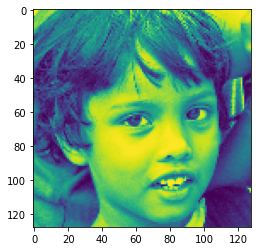

In [17]:
# Show the positive image
plt.imshow(images_positive[0])

# Print the relative positive label
print(positive_labels[0])

0


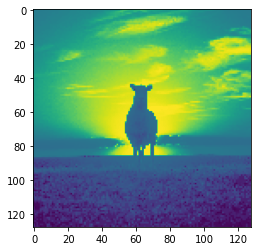

In [18]:
# Show the negative image
plt.imshow(images_negative[0])

# Print the relative negative label
print(negative_labels[0])

## 6 - Feature Engineering
Extraction of features from dataset using HOG (Histogram of Oriented Gradient) and LBP (Local Binary Pattern)

In [19]:
# Extract from images the HOG features and LBP features
images_feature_hog, image_hog = extract_features_from_list_image_hog(images)
images_feature_lbp = extract_features_from_list_image_lbp(images)

### 6.1 - Feature HOG and LBP exploration

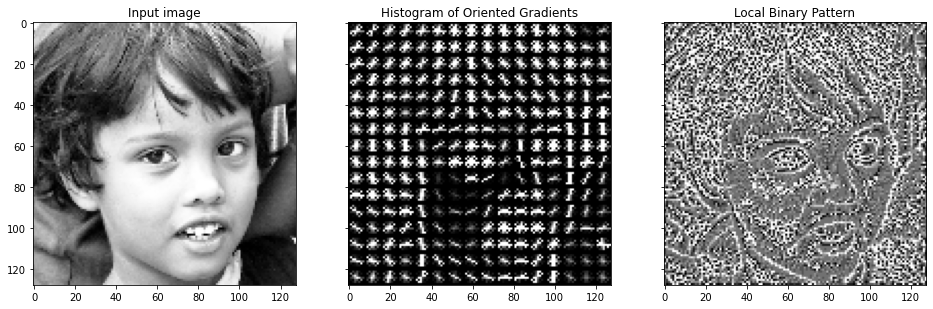

In [20]:
# Plot the images using the original one, hog features and lbp features
plot_image_and_features(images[0], image_hog[0], images_feature_lbp[0])

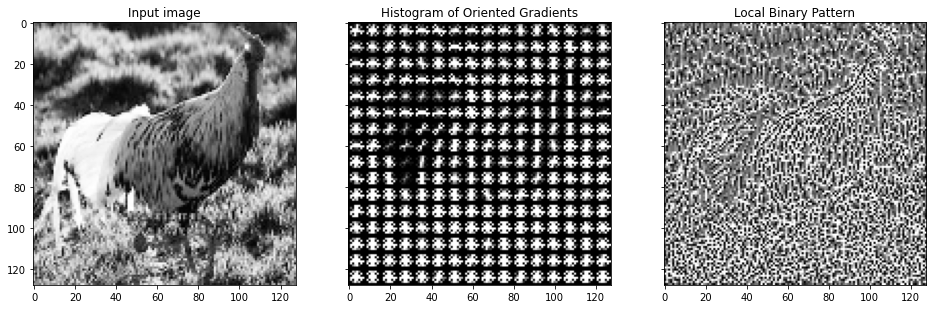

In [21]:
# Plot the images using the original one, hog features and lbp features
plot_image_and_features(images[2005], image_hog[2005], images_feature_lbp[2005] )

## 7 - Model Selection

### 7.1 - Train and Test dataset split

Split the features extracted from HOG and LBP techniques in two different dataset to train models.

In [22]:
# Split the data into train and test for LBP
X_train_lbp, X_test_lbp, y_train_lbp, y_test_lbp = train_test_split(images_feature_lbp, labels, test_size=.3, stratify=labels, random_state=RANDOM_SEED)

In [23]:
# Split the data into train and test for HOG
X_train_hog, X_test_hog, y_train_hog, y_test_hog = train_test_split(images_feature_hog, labels, test_size=.3, stratify=labels, random_state=RANDOM_SEED)

Reshape the features for model training phase.

In [24]:
# Execute the flattening for LBP and HOG features
X_train_lbp = X_train_lbp.reshape((X_train_lbp.shape[0], -1))
X_test_lbp = X_test_lbp.reshape((X_test_lbp.shape[0], -1))

X_train_hog = X_train_hog.reshape((X_train_hog.shape[0], -1))
X_test_hog = X_test_hog.reshape((X_test_hog.shape[0], -1))

# Check the shape of features
print(f'Train & Test features shape for HOG: {X_train_hog.shape}, {X_test_hog.shape}')
print(f'Train & Test features shape for LBP: {X_train_lbp.shape}, {X_test_lbp.shape}')

Train & Test features shape for HOG: (1459, 8100), (626, 8100)
Train & Test features shape for LBP: (1459, 16384), (626, 16384)


### 7.2 - Apply Standardization

In [25]:
# Apply standardization and take standard scaler object for HOG
ss_hog, X_train_hog, X_test_hog = apply_standardization(X_train_hog, X_test_hog)

In [26]:
# Apply standardization and take standard scaler object for LBP
ss_lbp, X_train_lbp, X_test_lbp = apply_standardization(X_train_lbp, X_test_lbp)

### 7.3 - PCA Analysis

Apply features standardization and PCA.
Standardization to make the features on the same level and PCA to reduce the dimensionality of dataset and reduce the overfitting.

In [27]:
# Calculate the variance explained using PCA for LBP and HOG
hog_var = compute_features_selection_on_PCA(X_train_hog, n_initial_features=min(X_train_hog.shape[0], X_train_hog.shape[1]))
lbp_var = compute_features_selection_on_PCA(X_train_lbp, n_initial_features=min(X_train_lbp.shape[0], X_train_lbp.shape[1]))

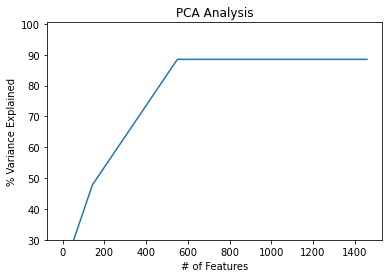

In [28]:
# Plot the variance explained for HOG
show_variance_explained_PCA(hog_var)

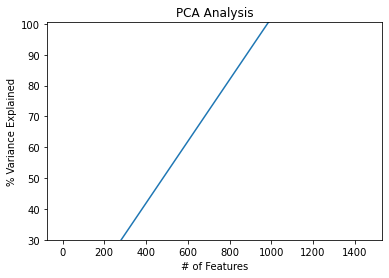

In [29]:
# Plot the variance explained for LBP
show_variance_explained_PCA(lbp_var)

As shown by plot the number of features enough to explain the majority part of data are:
- 1000 for LBP
- 600 for HOG

In [30]:
# Apply the PCA to HOG and LBP features
PCA_lbp, X_train_lbp, X_test_lbp = apply_PCA(1000, X_train_lbp, X_test_lbp)
PCA_hog, X_train_hog, X_test_hog = apply_PCA(600, X_train_hog, X_test_hog)

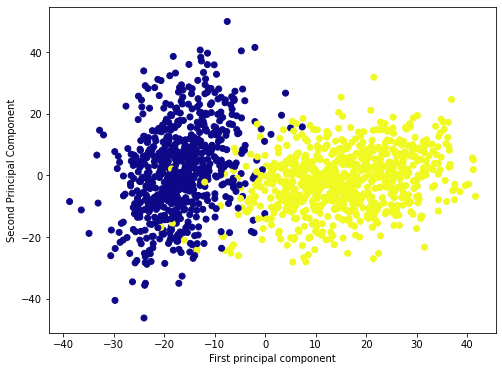

In [31]:
# Show the main components for HOG
show_features_PCA(X_train_hog, y_train_hog)

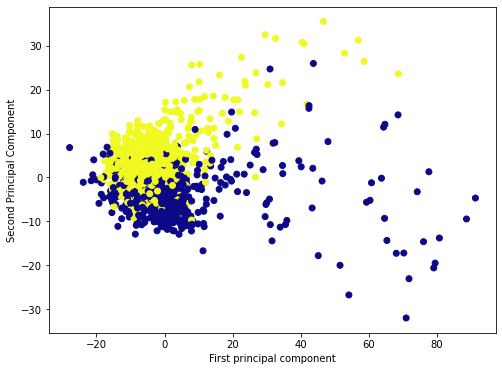

In [32]:
# Show the main components for LBP
show_features_PCA(X_train_lbp, y_train_lbp)

### 7.2 - Hyperparameters research

Try to search the best hyperparams to be configured on SVC model using RandomizedSearchCV and HalvingRandomizedSearchCV.

The parameter distribution to be used into research techique has been chosen using ProfAI, asking what is the most common used param distribution.

In [33]:
# Define the params grid
param_dist = {
    'C': scipy.stats.expon(scale=50),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': scipy.stats.expon(scale=.05),
    'degree': scipy.stats.randint(1, 5)
}

# Define cross validation numbers
cv = 2

# Define the number of iteration for randomized
n_iter = 3

# Initialize the model where the hyperparams need to be found
svc_model_for_research = SVC(probability=True)

Execute the hyperparams reasearch for HOG features.

In [34]:
# Find the hyperparams for SVC and hog features
# best_svc_randomized_hog = hyperparams_search_with_randomized(svc_model_for_research, param_dist, n_iter, cv, X_train_hog, y_train_hog)
best_svc_halving_hog = hyperparams_search_with_halving(svc_model_for_research, param_dist, cv, X_train_hog, y_train_hog)

Scores for Halving Random Search: 0.7773382257386385
Best params for Halving Random Search: {'C': 27.713423791504965, 'degree': 2, 'gamma': 0.04867362685170972, 'kernel': 'poly'}


Execute the hyperparams reasearch for LBP features.

In [35]:
# Find the hyperparams for SVC and lbp features
# best_svc_randomized_lbp = hyperparams_search_with_randomized(svc_model_for_research, param_dist, n_iter, cv, X_train_lbp, y_train_lbp)
best_svc_halving_lbp = hyperparams_search_with_halving(svc_model_for_research, param_dist, cv, X_train_lbp, y_train_lbp)

Scores for Halving Random Search: 0.752685089630394
Best params for Halving Random Search: {'C': 28.866215546479808, 'degree': 1, 'gamma': 0.1596473313271882, 'kernel': 'linear'}


### 7.3 - Model Creation

In [36]:
# Train the best estimator for HOG
best_svc_halving_hog.fit(X_train_hog, y_train_hog)

SVC(C=27.713423791504965, degree=2, gamma=0.04867362685170972, kernel='poly',
    probability=True)

In [37]:
# Evaluate the model HOG
evaluate_model(best_svc_halving_hog, X_train_hog, y_train_hog, X_test_hog, y_test_hog)

Cross-validated Accuracy:  0.9403662382902602

Log Loss on Train:  2.2204460492503136e-16

Log Loss on Test:  2.2204460492503136e-16

Classification report on Train: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       703
           1       1.00      1.00      1.00       756

    accuracy                           1.00      1459
   macro avg       1.00      1.00      1.00      1459
weighted avg       1.00      1.00      1.00      1459


Classification report on Test: 
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       293
           1       0.98      0.95      0.96       333

    accuracy                           0.96       626
   macro avg       0.96      0.96      0.96       626
weighted avg       0.96      0.96      0.96       626



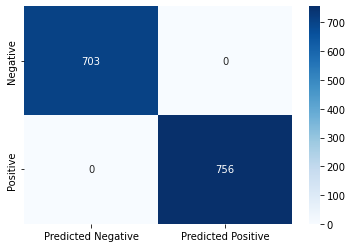

In [38]:
# Plot the confusion matrix for HOG in train
plot_confusion_matrix(y_train_hog, best_svc_halving_hog.predict(X_train_hog))

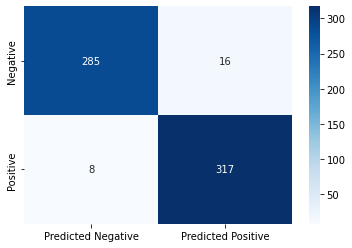

In [39]:
# Plot the confusion matrix for HOG in test
plot_confusion_matrix(y_test_hog, best_svc_halving_hog.predict(X_test_hog))

In [40]:
# Train the best estimator for LBP
best_svc_halving_lbp.fit(X_train_lbp, y_train_lbp)

SVC(C=28.866215546479808, degree=1, gamma=0.1596473313271882, kernel='linear',
    probability=True)

In [41]:
# Evaluate the model LBP
evaluate_model(best_svc_halving_lbp, X_train_lbp, y_train_lbp, X_test_lbp, y_test_lbp)

Cross-validated Accuracy:  0.7285599962340535

Log Loss on Train:  2.2204460492503136e-16

Log Loss on Test:  2.2204460492503136e-16

Classification report on Train: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       703
           1       1.00      1.00      1.00       756

    accuracy                           1.00      1459
   macro avg       1.00      1.00      1.00      1459
weighted avg       1.00      1.00      1.00      1459


Classification report on Test: 
               precision    recall  f1-score   support

           0       0.86      0.83      0.85       313
           1       0.84      0.87      0.85       313

    accuracy                           0.85       626
   macro avg       0.85      0.85      0.85       626
weighted avg       0.85      0.85      0.85       626



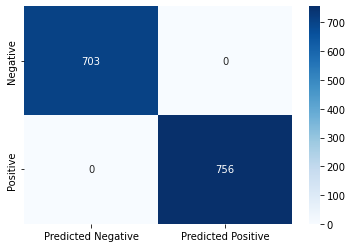

In [42]:
# Plot the confusion matrix for LBP in train
plot_confusion_matrix(y_train_lbp, best_svc_halving_lbp.predict(X_train_lbp))

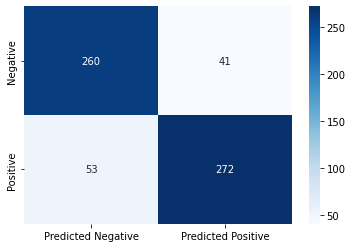

In [43]:
# Plot the confusion matrix for LBP in test
plot_confusion_matrix(y_test_lbp, best_svc_halving_lbp.predict(X_test_lbp))

Comparing the performance statistics between the two models trained with LBP and HOG features, it is evident that the HOG model achieves better results.

### 7.4 - Test Model

Execute some tests with positive and negative images.

The list is used to test the accuracy model for predictions.

In [45]:
# List of test images with expected result
image_test_path_with_expected_result = [
    (BASE_PATH + TEST_CLASSIFICATION_PATH + 'test_1.jpg', '1'),
    (BASE_PATH + TEST_CLASSIFICATION_PATH + 'test_2.jpg', '1'),
    (BASE_PATH + TEST_CLASSIFICATION_PATH + 'test_3.jpg', '1'),
    (BASE_PATH + TEST_CLASSIFICATION_PATH + 'test_4.jpg', '0'),
    (BASE_PATH + TEST_CLASSIFICATION_PATH + 'test_5.jpg', '0'),
    (BASE_PATH + TEST_CLASSIFICATION_PATH + 'test_6.jpg', '0')
]

In [46]:
for image_details in image_test_path_with_expected_result:
    image_test = cv2.imread(image_details[0])
    image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2GRAY)
    image_test = resize_image(image_test)

    features, _ = compute_hog(image_test)
    features = features.reshape((1, -1))
    features = ss_hog.transform(features)
    image_test_for_hog = PCA_hog.transform(features)

    print("HOG Result:")
    test_model(best_svc_halving_hog, image_test_for_hog, image_details[1])
    print('+'*50)
    print('\n')

HOG Result:
Test Passed! The test result is 1 and expected result 1
++++++++++++++++++++++++++++++++++++++++++++++++++


HOG Result:
Test Passed! The test result is 1 and expected result 1
++++++++++++++++++++++++++++++++++++++++++++++++++


HOG Result:
Test Passed! The test result is 1 and expected result 1
++++++++++++++++++++++++++++++++++++++++++++++++++


HOG Result:
Test Passed! The test result is 0 and expected result 0
++++++++++++++++++++++++++++++++++++++++++++++++++


HOG Result:
Test Passed! The test result is 0 and expected result 0
++++++++++++++++++++++++++++++++++++++++++++++++++


HOG Result:
Test Passed! The test result is 0 and expected result 0
++++++++++++++++++++++++++++++++++++++++++++++++++




## 8 - Face Detection

Face detection tests for a list of frontal faces.

In [96]:
# Create list of images to test bounding boxes
image_test_path_single_frontal_faces = [
    (BASE_PATH + TEST_FD_PATH + 'single_frontal_face_1.jpg'),
    (BASE_PATH + TEST_FD_PATH + 'single_frontal_face_2.jpg'),
    (BASE_PATH + TEST_FD_PATH + 'single_frontal_face_3.jpg')
]

In [92]:
# Create list of images to test bounding boxes
image_test_path_grouped_frontal_faces = [
    (BASE_PATH + TEST_FD_PATH + 'groped_frontal_face_1.jpg'),
    (BASE_PATH + TEST_FD_PATH + 'groped_frontal_face_2.jpg'),
    (BASE_PATH + TEST_FD_PATH + 'groped_frontal_face_3.jpg'),
    (BASE_PATH + TEST_FD_PATH + 'groped_frontal_face_4.jpg'),
]

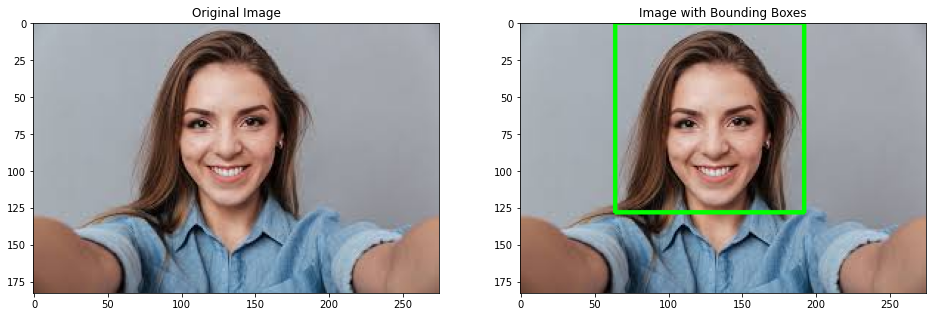

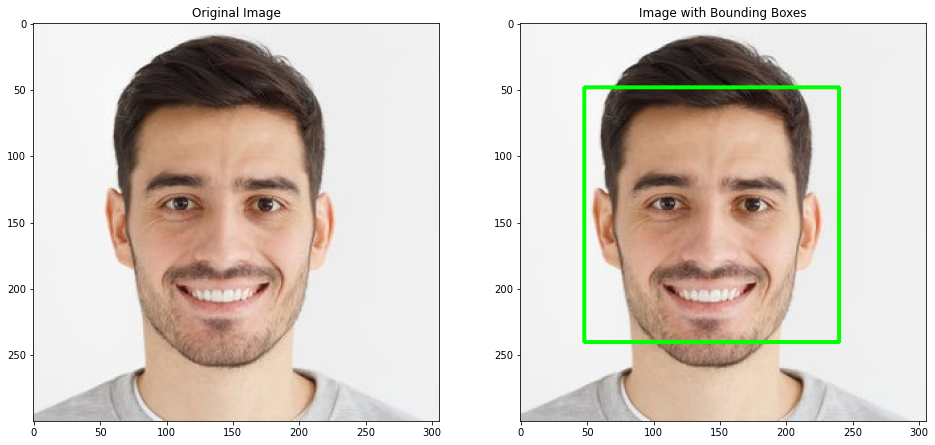

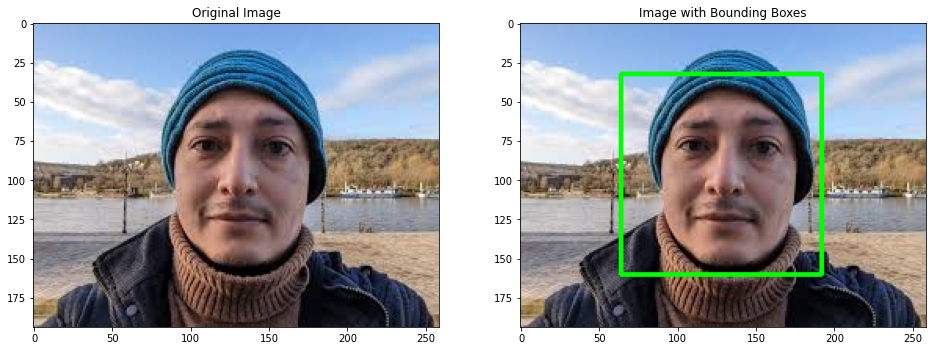

In [97]:
face_detection_process(image_test_path_single_frontal_faces, nms_threshold=0.4, iou_threshold=0.05)

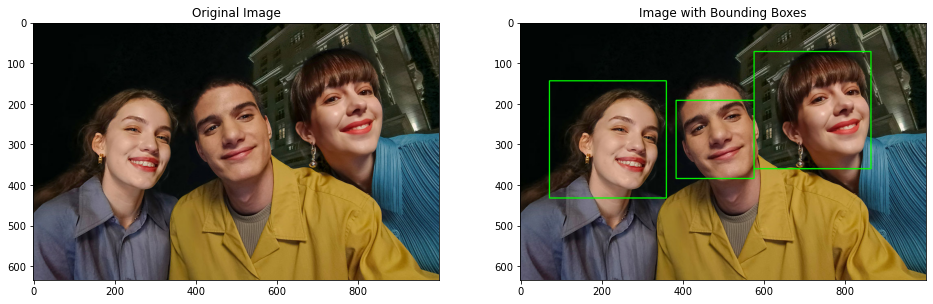

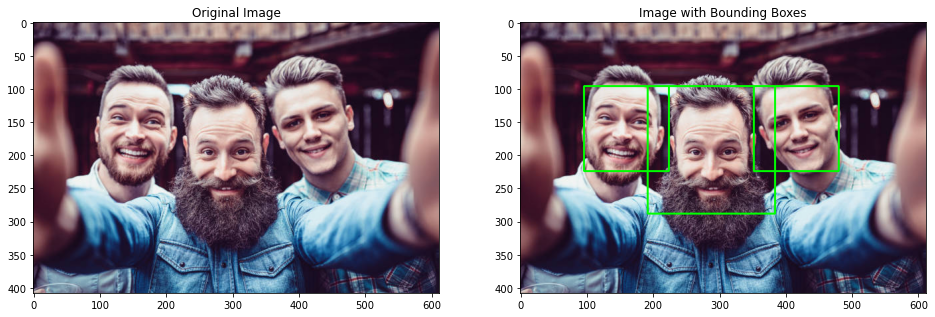

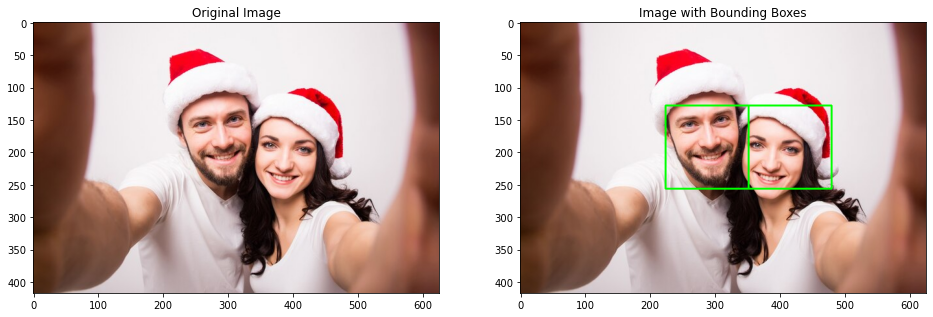

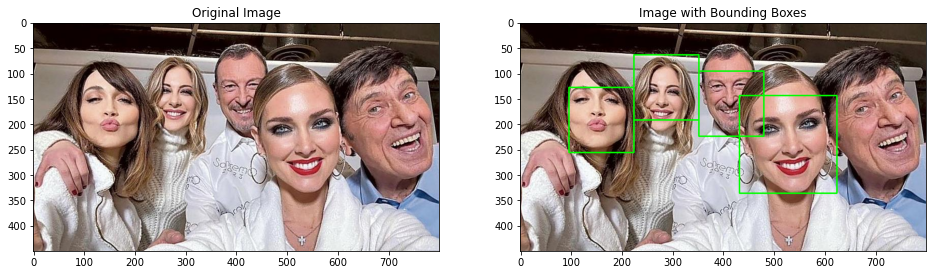

In [50]:
face_detection_process(image_test_path_grouped_frontal_faces, nms_threshold=0.3, iou_threshold=0.1)

## 9 - Face Detector Build

Build the Face Detector using class and defining the fit and transform methods in order to use it into Pipeline.

The Face Detector takes the SVC parameters in order to set the classifier and apply for each image path in input the Pyramid, Sliding Window, NMS and IOU in order to identify the faces and related bounding boxes.

In [79]:
class FaceDetector(BaseEstimator):
    """
    A class for detecting faces in images using a sliding window approach with support vector machines (SVM).
    
    The Face Detector accept the images already resized and in gray scale in numpy array.

    Parameters:
    - C: float, optional (default=1.0)
        Penalty parameter C of the error term.
    - degree: int, optional (default=3)
        Degree of the polynomial kernel function.
    - gamma: float, optional (default='scale')
        Kernel coefficient for 'rbf', 'poly', and 'sigmoid'.
    - kernel: string, optional (default='rbf')
        Specifies the kernel type to be used in the algorithm.
    - probability: bool, optional (default=False)
        Whether to enable probability estimates.
    - n_features_pca: int, optional (default=600)
        Number of components for PCA.
        
    IMPORTANT:
    - The class have a base configuration that could be used to identify the bounding box for a single frontal faces.
    The parameters NMS and IOU thresholds are really important to decide the final results of faces identifications.
    
    Suggested config:
    - Single Frontal Faces: NMS - 0.4 | IOU - 0.05
    - Grouped Frontal Faces: NMS - 3 | IOU - 0.1
    """
    def __init__(self, C=1.0, degree=3, gamma='scale', kernel='rbf', probability=False, n_features_pca=2, random_seed=0):
        self.svm_face_detector = SVC(C=C, degree=degree, gamma=gamma, kernel=kernel, probability=probability)
        self.nms_threshold = 0.4
        self.iou_threshold = 0.05
        self.sliding_window_accuracy_threshold = 0.99
        self.window_size = (128, 128)
        self.step_size = 32
        self.scale_pyramid = 1.5
        self.pca = PCA(n_components=n_features_pca)
        self.ss = StandardScaler()
        self.hog_orientations = 9
        self.hog_pixels_per_cell = (8, 8)
        self.hog_cells_per_block = (2, 2)
        self.hog_block_norm = 'L2-Hys'
        self.hog_visualize = True
        self.random_seed = random_seed

    def get_params(self, deep=True):
        return {
            'nms_threshold': self.nms_threshold,
            'iou_threshold': self.iou_threshold,
            'sliding_window_accuracy_threshold': self.sliding_window_accuracy_threshold,
            'window_size': self.window_size,
            'step_size': self.step_size,
            'scale_pyramid': self.scale_pyramid,
            'hog_orientations': self.hog_orientations,
            'hog_pixels_per_cell': self.hog_pixels_per_cell,
            'hog_cells_per_block': self.hog_cells_per_block,
            'hog_block_norm': self.hog_block_norm,
            'hog_visualize': self.hog_visualize
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

    def fit(self, X, y=None):
        """
        Fits the SVM model.

        Parameters:
        - X: array-like or sparse matrix, shape (n_samples, n_features)
            Training data.
        - y: array-like, shape (n_samples,)
            Target values.

        Returns:
        - self: object
            Returns self.
        """
        
        # Extract HOG features
        hog_features = self._extract_features_from_list_image_hog(X)

        # Apply the standardization
        X_train_scaled = self.ss.fit_transform(hog_features)

        # Apply PCA
        X_train_transformed = self.pca.fit_transform(X_train_scaled, self.random_seed)

        # Addestra il classificatore SVM
        self.svm_face_detector.fit(X_train_transformed, y)

        return self

    def transform(self, X):
        """
        Transform method for detecting faces in images.

        Parameters:
        - X: list
            List of image paths.

        Returns:
        - faces_list: list
            List of tuples containing image paths and corresponding detected faces.
        """
        
        # Initialize faces identified list
        faces_list = []

        for image_path in X:
            # Read original image
            original_image = cv2.imread(image_path)

            # Make grayscale image
            image = self._grayer_image(original_image)

            # Find faces on the image
            faces, confidences, number_resize = self._custom_sliding_windows_with_predictions(image)

            # Convert confidences and faces to numpy arrays
            confidences = np.array(confidences)
            faces = np.array(faces)

            # Rescale the bounding boxes
            faces_rescaled = self._rescale_bounding_boxes(faces, number_resize)

            # Apply NMS to delete bounding boxes with low probabilities
            final_faces_after_nms = self._non_max_suppression(np.array(faces_rescaled), confidences)

            # Apply IOU
            final_faces_after_iou = self._apply_iou(final_faces_after_nms)

            # Append to list the image path and related faces identified
            faces_list.append((image_path, final_faces_after_iou))

        return faces_list

    def _pyramid(self, image):
        """
        Generate an image pyramid.

        Parameters:
        - image: numpy array
            Input image.

        Yields:
        - Image pyramid levels.
        """
        
        # Yield the original image
        yield image

        # Keep looping over the pyramid
        while True:
            # Compute the new dimensions of the image and resize it
            w = int(image.shape[1] / self.scale_pyramid)
            image = imutils.resize(image, width=w)

            # If the resized image does not meet the supplied minimum
            # Size, then stop constructing the pyramid
            if image.shape[0] < self.window_size[1] or image.shape[1] < self.window_size[0]:
                break

            # Yield the next image in the pyramid
            yield image

    def _sliding_window(self, image):
        """
        Generate sliding windows over an image.

        Parameters:
        - image: numpy array
            Input image.

        Yields:
        - Sliding windows.
        """
        
        # Slide a window across the image
        for y in range(0, image.shape[0] - self.window_size[1], self.step_size):
            for x in range(0, image.shape[1] - self.window_size[0], self.step_size):
                
                # Yield the current window
                yield (x, y, image[y:y + self.window_size[1], x:x + self.window_size[0]])

    def _compute_hog(self, image):
        """
        Extract features with Histogram of Oriented Gradients.

        Parameters:
        - image: ndarray
            Image to extract features.

        Returns:
        - ndarray
            HOG features extracted.
        """
        
        # Initialize HOG class
        hog_feature, _ = hog(image,
                             orientations=self.hog_orientations,
                             pixels_per_cell=self.hog_pixels_per_cell,
                             cells_per_block=self.hog_cells_per_block,
                             block_norm=self.hog_block_norm,
                             visualize=self.hog_visualize)

        hog_feature = exposure.equalize_hist(hog_feature)

        # Extract features from image
        return hog_feature

    def _grayer_image(self, image):
        """
        Execute the transform into gray scale of image.

        Parameters:
        - image: ndarray
            Image to be grayed.

        Returns:
        - ndarray
            Image in gray scale.
        """
        
        # Return the image in gray scale
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    def _extract_features_from_list_image_hog(self, image_list):
        """
        Function used to extract from a list of images the Local Binary Pattern features.

        Parameters:
        - image_list: list
            Image list from which to extract features.

        Returns:
        - ndarray
            HOG features extracted.
        """
        
        # Initialize hog feature list
        image_hog_features = []

        # Loop over images into list
        for img in image_list:
            
            # Extract the hog features and hog image
            hog_feature = self._compute_hog(img)

            # Append the feature and image to hog lists
            image_hog_features.append(hog_feature)

        # Return numpy arrays of hog features and hog images
        return np.array(image_hog_features)

    def _non_max_suppression(self, boxes, scores):
        """
        Apply non-maximum suppression (NMS) to a list of bounding boxes based on scores and a threshold.

        Parameters:
        - boxes: List of bounding boxes, each represented as a tuple (x1, y1, x2, y2)
        - scores: List of scores corresponding to the bounding boxes

        Returns:
        - List of indices of selected bounding boxes after NMS
        """
        
        # Check if the list of bounding boxes is different from 0
        if len(boxes) == 0:
            return []

        # Initialize the list of picked bounding boxes
        pick = []

        # Get the coordinates of the bounding boxes
        x1 = boxes[:, 0]
        y1 = boxes[:, 1]
        x2 = boxes[:, 2]
        y2 = boxes[:, 3]

        # Compute the area of the bounding boxes and sort the bounding boxes by the bottom-right y-coordinate of the bounding box
        area = (x2 - x1 + 1) * (y2 - y1 + 1)
        idxs = np.argsort(scores)

        # Keep looping while some bounding boxes remain
        while len(idxs) > 0:
            # Grab the last index in the list and add its index to the list of picked bounding boxes
            last = len(idxs) - 1
            i = idxs[last]
            pick.append(i)

            # Find the intersection
            xx1 = np.maximum(x1[i], x1[idxs[:last]])
            yy1 = np.maximum(y1[i], y1[idxs[:last]])
            xx2 = np.minimum(x2[i], x2[idxs[:last]])
            yy2 = np.minimum(y2[i], y2[idxs[:last]])

            # Compute the width and height of the bounding box
            w = np.maximum(0, xx2 - xx1 + 1)
            h = np.maximum(0, yy2 - yy1 + 1)

            # Compute the ratio of overlap
            overlap = (w * h) / area[idxs[:last]]

            # Delete all bounding boxes with overlap greater than the provided threshold
            idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > self.nms_threshold)[0])))

        # Return only the bounding boxes that were picked
        return [boxes[i] for i in pick]

    def _calculate_iou(self, boxA, boxB):
        """
        Calculate Intersection over Union (IoU) between two bounding boxes.

        Parameters:
        - boxA: tuple
            Bounding box coordinates (x1, y1, x2, y2).
        - boxB: tuple
            Bounding box coordinates (x1, y1, x2, y2).

        Returns:
        - iou: float
            Intersection over Union value.
        """
        
        # Determine the coordinates of the intersection rectangle
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])

        # Compute the area of intersection rectangle
        interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

        # Compute the area of both the prediction and ground-truth rectangles
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

        # Compute the IoU by taking the intersection area and dividing it by the sum of prediction + ground-truth areas - the intersection area
        iou = interArea / float(boxAArea + boxBArea - interArea)

        # Return the intersection over union value
        return iou

    def _custom_sliding_windows_with_predictions(self, image):
        """
        Sliding window approach with predictions for face detection.

        Parameters:
        - image: numpy array
            Input image.

        Returns:
        - faces: list
            List of detected faces as bounding boxes.
        - confidences: list
            List of confidence scores corresponding to the detected faces.
        - number_resize: list
            List of indices indicating the number of resize operations performed on the image.
        """
        
        # Initialize the faces list
        faces = []
        
        # Initialize the list of confidences
        confidences = []
        
        # Initialize the list of resize and counter of it
        number_resize = []
        n_resize = -1

        for resized in self._pyramid(image):
            n_resize += 1
            for (x, y, window) in self._sliding_window(resized):
                
                # if the window does not meet our desired window size, ignore it
                if window.shape[0] != self.window_size[0] or window.shape[1] != self.window_size[1]:
                    continue

                # Extract the HOG and apply the transformation for image
                features = self._compute_hog(window)
                features = features.reshape((1, -1))
                features = self.ss.transform(features)
                features = self.pca.transform(features)

                # Execute the prediction and take related probability
                prediction = self.svm_face_detector.predict(features)
                prediction_proba = self.svm_face_detector.predict_proba(features)[0, 1]

                # If face is found on image, save the bounding box and related probability
                if prediction == 1 and prediction_proba > self.sliding_window_accuracy_threshold:
                    faces.append((x, y, x + self.window_size[0], y + self.window_size[1]))
                    number_resize.append(n_resize)
                    confidences.append(prediction_proba)

        return faces, confidences, number_resize

    def _rescale_bounding_boxes(self, boxes, number_resize):
        """
        Rescale bounding boxes based on the number of resize operations.

        Parameters:
        - boxes: list
            List of bounding boxes.
        - number_resize: list
            List of indices indicating the number of resize operations performed on the image.

        Returns:
        - rescaled_boxes: list
            List of rescaled bounding boxes.
        """
        
        # Initialize the list of resized bboxes
        rescaled_boxes = []
        
        for i, box in enumerate(boxes):
            
            # Takes the coordinates
            x1, y1, x2, y2 = box
            
            # Calculate the ratio of resize
            ratio = self.scale_pyramid ** number_resize[i]
            
            # Rescale the bounding boxe
            rescaled_box = (int(x1 * ratio), int(y1 * ratio), int(x2 * ratio), int(y2 * ratio))
            
            # Append the rescaled bounding box to list
            rescaled_boxes.append(rescaled_box)
            
        return rescaled_boxes

    def _apply_iou(self, boxes):
        """
        Apply Intersection over Union (IoU) to filter bounding boxes.

        Parameters:
        - boxes: list
            List of bounding boxes in the format (x1, y1, x2, y2, confidence).

        Returns:
        - boxes_after_iou: list
            Filtered bounding boxes after applying IoU.
        """
        
        # Initialize list of bounding boxes
        boxes_after_iou = []

        for i in range(len(boxes)):
            keep = True
            for j in range(i + 1, len(boxes)):
                
                # Check if the IoU between two bounding boxes is greater than the threshold
                if self._calculate_iou(boxes[i], boxes[j]) > self.iou_threshold:
                    keep = False
                    break
                    
            # Keep the bounding box if it satisfies the IoU condition
            if keep:
                boxes_after_iou.append(boxes[i])

        return boxes_after_iou


## 10 - Pipeline

### 10.1 Pipeline Creation

Take the Face Detector builded into Pipeline.

In [80]:
# Pipeline creation with parameters of SVC studied before
pipeline_face_detection = Pipeline([
    ('face_detector', FaceDetector(C=27.713423791504965, 
                                   degree=2, 
                                   gamma=0.04867362685170972, 
                                   kernel='poly',
                                   probability=True, 
                                   n_features_pca=600))
    ])

In [81]:
# Fit the pipeline with the images and labels used for the model studied before
pipeline_face_detection.fit(images, labels)

Pipeline(steps=[('face_detector',
                 FaceDetector(hog_block_norm='L2-Hys',
                              hog_cells_per_block=(2, 2), hog_orientations=9,
                              hog_pixels_per_cell=(8, 8), hog_visualize=True,
                              iou_threshold=0.05, nms_threshold=0.4,
                              scale_pyramid=1.5,
                              sliding_window_accuracy_threshold=0.99,
                              step_size=32, window_size=(128, 128)))])

### 10.3 - Pipeline Test

Take some images in order to test the pipeline and print the results.

In [98]:
# Test the pipeline on image with single frontal faces
frontal_faces_list = pipeline_face_detection.transform(image_test_path_single_frontal_faces)

In [99]:
print_number_faces_identified(frontal_faces_list)

The pipeline has found the following number of faces:
Image: C:\Users\39366\Desktop\face_detector_project\fd_model_tests\single_frontal_face_1.jpg
Number of faces: 1
Bounding Box: [ 64   0 192 128]
Image: C:\Users\39366\Desktop\face_detector_project\fd_model_tests\single_frontal_face_2.jpg
Number of faces: 1
Bounding Box: [ 48  48 240 240]
Image: C:\Users\39366\Desktop\face_detector_project\fd_model_tests\single_frontal_face_3.jpg
Number of faces: 1
Bounding Box: [ 64  32 192 160]


In [88]:
# Change the pipeline configuration for grouped frontal faces
pipeline_face_detection.set_params(face_detector__nms_threshold=0.3, face_detector__iou_threshold=0.1)

Pipeline(steps=[('face_detector',
                 FaceDetector(hog_block_norm='L2-Hys',
                              hog_cells_per_block=(2, 2), hog_orientations=9,
                              hog_pixels_per_cell=(8, 8), hog_visualize=True,
                              iou_threshold=0.05, nms_threshold=0.4,
                              scale_pyramid=1.5,
                              sliding_window_accuracy_threshold=0.99,
                              step_size=32, window_size=(128, 128)))])

In [85]:
# Test the pipeline on image with grouped frontal faces
grouped_faces_list = pipeline_face_detection.transform(image_test_path_grouped_frontal_faces)

In [86]:
print_number_faces_identified(grouped_faces_list)

The pipeline has found the following number of faces:
Image: C:\Users\39366\Desktop\face_detector_project\fd_model_tests\groped_frontal_face_1.jpg
Number of faces: 4
Bounding Box: [384 192 576 384]
Bounding Box: [144 192 336 384]
Bounding Box: [672  96 864 288]
Bounding Box: [160 352 288 480]
Image: C:\Users\39366\Desktop\face_detector_project\fd_model_tests\groped_frontal_face_2.jpg
Number of faces: 3
Bounding Box: [352  96 480 224]
Bounding Box: [ 96  96 224 224]
Bounding Box: [192  96 384 288]
Image: C:\Users\39366\Desktop\face_detector_project\fd_model_tests\groped_frontal_face_3.jpg
Number of faces: 2
Bounding Box: [352 128 480 256]
Bounding Box: [224 128 352 256]
Image: C:\Users\39366\Desktop\face_detector_project\fd_model_tests\groped_frontal_face_4.jpg
Number of faces: 4
Bounding Box: [224  64 352 192]
Bounding Box: [576  96 768 288]
Bounding Box: [ 32  96 160 224]
Bounding Box: [352  64 480 192]


### 10.3 - Pipeline Export

Export the pipeline for future use.

In [100]:
joblib.dump(pipeline_face_detection, 'pipeline_face_detection.joblib')

['pipeline_face_detection.joblib']

## 11 - Conclusion

After exeuting all the steps above descripted, for the dataset chosen the best model and technique of feature engineering was the combination of SVC with kernel poly and HOG.

The pipeline was created in order to include the process of bounding boxes identification and then to identify the faces of image directly with pipeline. 
It returns the coordinates of bounding boxes for original image and it can be configured on the needs required from dataset used.